## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres:

                     Names                 User                Code
       - Romero Fonseca Angela Fernanda       af.romerof     201819276       
       - Juan Fernando Ortiz Serrano          jf.ortiz43     200623117
       - Elquin Huertas Ramírez               e.huertas      201920061

**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

In [ ]:
import numpy as np
import keras
from keras import layers
from keras.models import load_model, Sequential

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 


También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [ ]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [ ]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step
25000 secuencias de entrenamiento
25000 secuencias de validación


**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la primera observación de entrenamiento:

In [ ]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [ ]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

1646592/1641221 [==============================] - 0s 0us/step


Veamos el primer comentario de entrenamiento que es positivo:

In [ ]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [ ]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [ ]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de pérdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 28s 72ms/step - loss: 0.4541 - accuracy: 0.7838 - val_loss: 0.3332 - val_accuracy: 0.8653
Epoch 2/3
391/391 [==============================] - 27s 68ms/step - loss: 0.2255 - accuracy: 0.9166 - val_loss: 0.3793 - val_accuracy: 0.8475
Epoch 3/3
391/391 [==============================] - 26s 68ms/step - loss: 0.1361 - accuracy: 0.9538 - val_loss: 0.4841 - val_accuracy: 0.8243
Desempeño (exactitud): accu_v1=0.8243200182914734 , accu_v2=0.815280020236969
Epoch 1/3
391/391 [==============================] - 28s 72ms/step - loss: 0.2367 - accuracy: 0.9145 - val_loss: 0.2149 - val_accuracy: 0.9223
Epoch 2/3
391/391 [==============================] - 27s 69ms/step - loss: 0.1098 - accuracy: 0.9652 - val_loss: 0.3219 - val_accuracy: 0.9004
Epoch 3/3
391/391 [==============================] - 27s 69ms/step - loss: 0.0690 - accuracy: 0.9792 - val_loss: 0.3456 - val_accuracy: 0.8876
Desempeño (exactitud): accu_v1=0.8876000046730042 , accu_v2=0.83

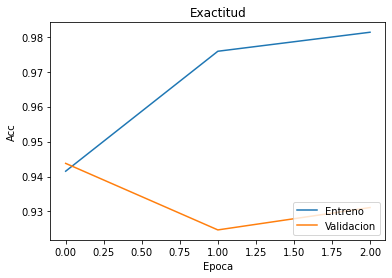

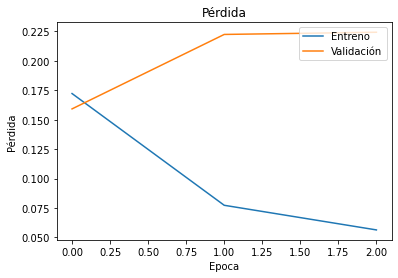

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [ ]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part=3.h5')

model_brnn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [ ]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11861   639]
 [ 2036 10464]]
Exactitud:  0.8930000066757202


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [ ]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[11198  1302]
 [ 3316  9184]]
Exactitud:  0.815280020236969


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con esta red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

#### Red recurrente simple LSTM 

- Siguiendo el modelo propuesto por el enunciado, se procede a estimar una RNN unidireccional del tipo LSTM, toda vez que esta permite pronosticar el sentimiento de un comentario con base en secuencias de texto más largas que aquellas capturadas por una Red Neuronal Recurrente Simple (SimpleRNN en Keras). Para la arquitectura de esta red, añadimos dos unidades LSTM unidireccionales de entrada.

- Debido a que a la activación sigmoide es particularmente útil para resolver problemas de clasificación binarios, consideramos conveniente dejarla para nuestro modelo inicial. 

In [ ]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de pérdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('LSTM64_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 20s 51ms/step - loss: 0.4370 - accuracy: 0.7946 - val_loss: 0.3244 - val_accuracy: 0.8641
Epoch 2/3
391/391 [==============================] - 19s 48ms/step - loss: 0.2290 - accuracy: 0.9156 - val_loss: 0.3623 - val_accuracy: 0.8459
Epoch 3/3
391/391 [==============================] - 19s 49ms/step - loss: 0.1420 - accuracy: 0.9490 - val_loss: 0.4531 - val_accuracy: 0.8245
Desempeño (exactitud): accu_v1=0.8244799971580505 , accu_v2=0.8169599771499634
Epoch 1/3
391/391 [==============================] - 21s 53ms/step - loss: 0.2334 - accuracy: 0.9121 - val_loss: 0.2315 - val_accuracy: 0.9145
Epoch 2/3
391/391 [==============================] - 20s 50ms/step - loss: 0.1057 - accuracy: 0.9658 - val_loss: 0.3537 - val_accuracy: 0.9045
Epoch 3/3
391/391 [==============================] - 20s 51ms/step - loss: 0.0658 - accuracy: 0.9798 - val_loss: 0.3532 - val_accuracy: 0.8937
Desempeño (exactitud): accu_v1=0.8936799764633179 , accu_v2=0.8

- Al analizar los resultados de iterar sobre las tres épocas, se observa que el modelo pierde precisión en los datos de validación, siendo esta de 0.8154399991035461. En este sentido, a pesar the que la red LSTM permite traer información de pasos previos a pasos posteriores con mayor facilidad que la RNN, este modelo no garantiza la convergencia en la precisión de los datos de entrenamiento y validación.

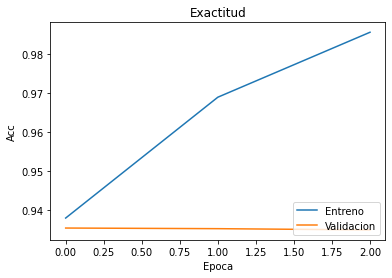

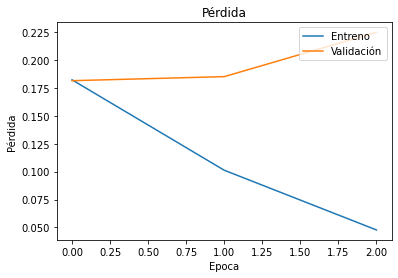

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [ ]:
# LSTM 64
model_lstm64 = load_model('LSTM64_part=3.h5')

model_lstm64.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Y_predt = model_lstm64.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_lstm64.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[10367  2133]
 [  572 11928]]
Exactitud:  0.8917999863624573


In [ ]:
Y_predv = model_lstm64.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_lstm64.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9101  3399]
 [ 1177 11323]]
Exactitud:  0.8169599771499634


- Al analizar los resultados de iterar sobre las tres épocas, se observa que el modelo pierde precisión en los datos de validación, siendo esta de 0.8169599771499634. En este sentido, a pesar the que la red LSTM permite traer información de pasos previos a pasos posteriores con mayor facilidad que la RNN, este modelo no garantiza la convergencia en la precisión de los datos de entrenamiento y validación.

#### Red recurrente LSTM

- Con el propósito de estimar el comportamiento de la red LSTM con otros parámetros, se estima una red con LSTM similar a la anterior pero con una activación de tangente hiperbólica en la capa de salida

In [ ]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades 
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="tanh")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


- Para el algoritmo de Optimización Adam definimos una tasa de aprendizaje menor que la propuesta por el enunciado. De otra parte, al analizar las diferentes estimaciones de las funciones de pérdida, se estimó conveniente dejar la estimación de la función de pérdida por medio de binary_crossentropy, ya que garantiza buenos resultados en los problemas de clasificación binarios.

In [ ]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.009, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de pérdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('LSTM_2_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 21s 53ms/step - loss: 0.5471 - accuracy: 0.7464 - val_loss: 0.3983 - val_accuracy: 0.8543
Epoch 2/3
391/391 [==============================] - 19s 49ms/step - loss: 0.2368 - accuracy: 0.9160 - val_loss: 0.3907 - val_accuracy: 0.8619
Epoch 3/3
391/391 [==============================] - 19s 50ms/step - loss: 0.1446 - accuracy: 0.9622 - val_loss: 0.5402 - val_accuracy: 0.8599
Desempeño (exactitud): accu_v1=0.8599200248718262 , accu_v2=0.8369200229644775
Epoch 1/3
391/391 [==============================] - 20s 51ms/step - loss: 0.2378 - accuracy: 0.9143 - val_loss: 0.2322 - val_accuracy: 0.9190
Epoch 2/3
391/391 [==============================] - 19s 48ms/step - loss: 0.1674 - accuracy: 0.9521 - val_loss: 0.3494 - val_accuracy: 0.8984
Epoch 3/3
391/391 [==============================] - 19s 48ms/step - loss: 0.1828 - accuracy: 0.9611 - val_loss: 0.7752 - val_accuracy: 0.8844
Desempeño (exactitud): accu_v1=0.8844000101089478 , accu_v2=0.8

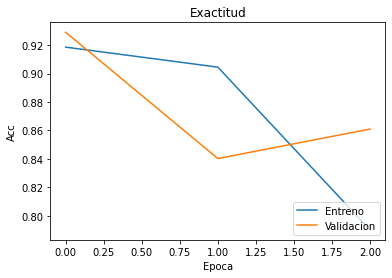

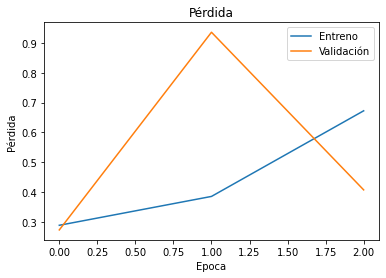

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [ ]:
# LSTM RELU
model_lstm2 = load_model('LSTM_2_part=3.h5')

model_lstm2.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Y_predt = model_lstm2.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_lstm2.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11656   844]
 [ 1143 11357]]
Exactitud:  0.920520007610321


In [ ]:
Y_predv = model_lstm2.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_lstm2.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10847  1653]
 [ 2424 10076]]
Exactitud:  0.8369200229644775


- Al analizar los resultados de iterar sobre las tres épocas, se observa que el modelo pierde precisión en los datos de validación, siendo esta de 0.8369200229644775. En este sentido, a pesar the que la red LSTM permite traer información de pasos previos a pasos posteriores con mayor facilidad que la RNN, este modelo no garantiza la convergencia en la precisión de los datos de entrenamiento y validación.

## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

#### Red de gradiente recurrente GRU - Softmax

- Red de gradiente recurrente GRU con función de activación Softmax en la capa y función de activación sigmoide en la capa de salida, tasa de aprendizaje 0.001

In [40]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 4 unidades 
x = layers.GRU(32, activation="softmax", return_sequences=True)(x)
x = layers.GRU(32)(x)



# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_8 (GRU)                  (None, None, 32)          15552     
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 2,581,921
Trainable params: 2,581,921
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de pérdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('GRU32_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 175s 448ms/step - loss: 0.4875 - accuracy: 0.7416 - val_loss: 0.3100 - val_accuracy: 0.8638
Epoch 2/3
391/391 [==============================] - 175s 447ms/step - loss: 0.1905 - accuracy: 0.9241 - val_loss: 0.4135 - val_accuracy: 0.8599
Epoch 3/3
391/391 [==============================] - 176s 450ms/step - loss: 0.0872 - accuracy: 0.9697 - val_loss: 0.4573 - val_accuracy: 0.8591
Desempeño (exactitud): accu_v1=0.8591200113296509 , accu_v2=0.8415600061416626
Epoch 1/3
391/391 [==============================] - 174s 445ms/step - loss: 0.2127 - accuracy: 0.9189 - val_loss: 0.2067 - val_accuracy: 0.9234
Epoch 2/3
391/391 [==============================] - 175s 446ms/step - loss: 0.0934 - accuracy: 0.9654 - val_loss: 0.2858 - val_accuracy: 0.9040
Epoch 3/3
391/391 [==============================] - 175s 448ms/step - loss: 0.0593 - accuracy: 0.9795 - val_loss: 0.2958 - val_accuracy: 0.9077
Desempeño (exactitud): accu_v1=0.9076799750328064 ,

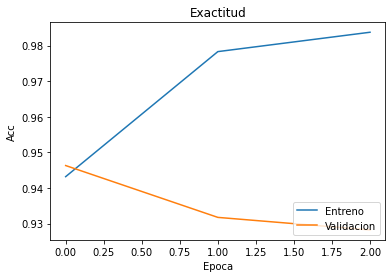

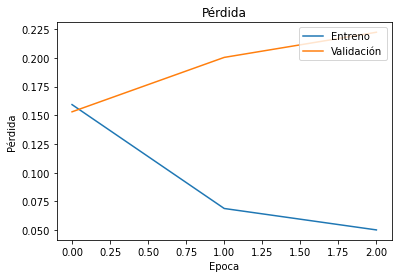

In [42]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [43]:
# GRU 32
model_gru32 = load_model('GRU32_part=3.h5')

model_gru32.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_8 (GRU)                  (None, None, 32)          15552     
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 2,581,921
Trainable params: 2,581,921
Non-trainable params: 0
_________________________________________________________________


In [44]:
Y_predt = model_gru32.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_gru32.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11536   964]
 [ 1004 11496]]
Exactitud:  0.921280026435852


In [45]:
Y_predv = model_gru32.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_gru32.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10594  1906]
 [ 2055 10445]]
Exactitud:  0.8415600061416626


- Al analizar los resultados de iterar sobre las tres épocas, se observa que aunque el modelo mejora su exactitud (0.8415600061416626) esta no es suficiente para concluir que este es el mejor modelo.Por lo tanto, este modelo no garantiza la convergencia en la precisión de los datos de entrenamiento y validación.

#### Red de gradiente recurrente GRU32

- Red de gradiente recurrente GRU con Softmax y capa de salida sigmoide. Tasa de aprendizaje 0.05 y representación de cada entero en un vector de 32 dimensiones

In [ ]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 32)(inputs)

# Añadimos 2 unidades 
x = layers.GRU(16, activation="softmax", return_sequences=True)(x)
x = layers.GRU(16)(x)



# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 32)          640000    
_________________________________________________________________
gru_10 (GRU)                 (None, None, 16)          2400      
_________________________________________________________________
gru_11 (GRU)                 (None, 16)                1632      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 644,049
Trainable params: 644,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.05, beta_1 = 0.8, beta_2 = 0.888)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de pérdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('GRU32_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 169s 433ms/step - loss: 0.4728 - accuracy: 0.7637 - val_loss: 0.3490 - val_accuracy: 0.8495
Epoch 2/3
391/391 [==============================] - 165s 423ms/step - loss: 0.2621 - accuracy: 0.8924 - val_loss: 0.3789 - val_accuracy: 0.8395
Epoch 3/3
391/391 [==============================] - 168s 429ms/step - loss: 0.2186 - accuracy: 0.9138 - val_loss: 0.4845 - val_accuracy: 0.8136
Desempeño (exactitud): accu_v1=0.8136000037193298 , accu_v2=0.7940000295639038
Epoch 1/3
391/391 [==============================] - 164s 420ms/step - loss: 0.2822 - accuracy: 0.8853 - val_loss: 0.2723 - val_accuracy: 0.8891
Epoch 2/3
391/391 [==============================] - 164s 419ms/step - loss: 0.2385 - accuracy: 0.9072 - val_loss: 0.2780 - val_accuracy: 0.8888
Epoch 3/3
391/391 [==============================] - 165s 422ms/step - loss: 0.2035 - accuracy: 0.9216 - val_loss: 0.3381 - val_accuracy: 0.8830
Desempeño (exactitud): accu_v1=0.8830400109291077 ,

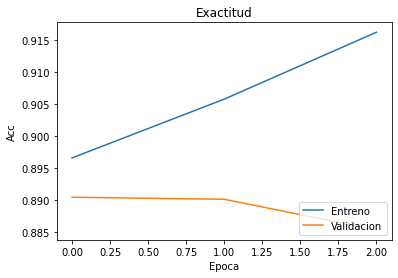

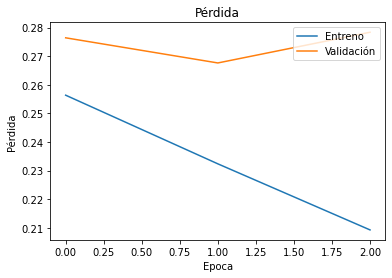

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [ ]:
# GRU 32
model_gru32 = load_model('GRU32_part=3.h5')

model_gru32.summary()

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 32)          640000    
_________________________________________________________________
gru_10 (GRU)                 (None, None, 16)          2400      
_________________________________________________________________
gru_11 (GRU)                 (None, 16)                1632      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 644,049
Trainable params: 644,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Y_predt = model_gru32.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_gru32.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11812   688]
 [ 2647  9853]]
Exactitud:  0.866599977016449


In [ ]:
Y_predv = model_gru32.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_gru32.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[11404  1096]
 [ 4054  8446]]
Exactitud:  0.7940000295639038


* Al analizar los resultados de iterar sobre las tres épocas, se observa que el modelo pierde precisión en los datos de validación, siendo esta de 0.7940000295639038. En este sentido, este modelo no garantiza la convergencia en la precisión de los datos de entrenamiento y validación.

#### Red de gradiente recurrente GRU - RELU

- Red de gradiente recurrente GRU con ReLu y capa de salida sigmoide. Tasa de aprendizaje 0.001 y representación de cada entero en un vector de 110 dimensiones

In [ ]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 110-dimensional
x = layers.Embedding(max_features, 110)(inputs)

# Añadimos 2 unidades 
x = layers.GRU(55, activation="relu", return_sequences=True)(x)
x = layers.GRU(55)(x)



# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 110)         2200000   
_________________________________________________________________
gru_6 (GRU)                  (None, None, 55)          27555     
_________________________________________________________________
gru_7 (GRU)                  (None, 55)                18480     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 56        
Total params: 2,246,091
Trainable params: 2,246,091
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de pérdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('GRU55_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 171s 438ms/step - loss: 0.4960 - accuracy: 0.7434 - val_loss: 0.3458 - val_accuracy: 0.8582
Epoch 2/3
391/391 [==============================] - 170s 434ms/step - loss: 0.2361 - accuracy: 0.9081 - val_loss: 0.3279 - val_accuracy: 0.8700
Epoch 3/3
391/391 [==============================] - 168s 430ms/step - loss: 0.1460 - accuracy: 0.9501 - val_loss: 0.4070 - val_accuracy: 0.8641
Desempeño (exactitud): accu_v1=0.864080011844635 , accu_v2=0.8408399820327759
Epoch 1/3
391/391 [==============================] - 169s 433ms/step - loss: 0.2166 - accuracy: 0.9216 - val_loss: 0.2084 - val_accuracy: 0.9237
Epoch 2/3
391/391 [==============================] - 169s 433ms/step - loss: 0.1059 - accuracy: 0.9674 - val_loss: 0.3111 - val_accuracy: 0.9012
Epoch 3/3
391/391 [==============================] - 169s 431ms/step - loss: 0.0568 - accuracy: 0.9828 - val_loss: 0.3309 - val_accuracy: 0.9078
Desempeño (exactitud): accu_v1=0.9077600240707397 , 

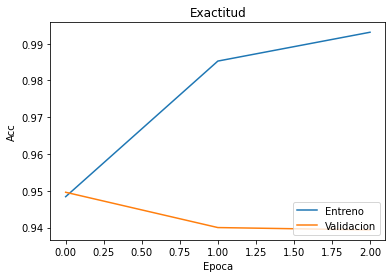

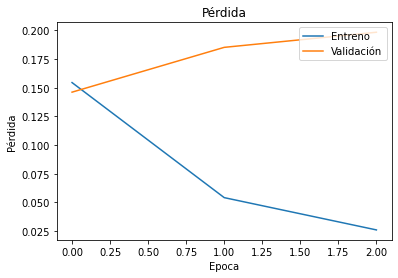

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [ ]:
# GRU 8
model_gru55 = load_model('GRU55_part=3.h5')

model_gru55.summary()

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 110)         2200000   
_________________________________________________________________
gru_6 (GRU)                  (None, None, 55)          27555     
_________________________________________________________________
gru_7 (GRU)                  (None, 55)                18480     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 56        
Total params: 2,246,091
Trainable params: 2,246,091
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Y_predt = model_gru55.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_gru55.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11929   571]
 [ 1494 11006]]
Exactitud:  0.9174000024795532


In [ ]:
Y_predv = model_gru55.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_gru55.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[11418  1082]
 [ 2897  9603]]
Exactitud:  0.8408399820327759


- Se evidencia que al reducir las dimensiones del vector, en este caso en 110, se presenta una mejor exactitud en validación (0.8408399820327759) que en los anteriores modelos.


# Conclusiones


*   Al disminuir el número de dimensiones del vector representado se obtienen mejores estimaciones respecto al sentimiento de los comentarios de la base de datos de IMDB. Esto es particularmente cierto en la red GRU, donde se probaron vectores de 110 y 32 dimensiones. El modelo de 110 dimensiones arrojó la mejor estimación de las obtenidas al calcularla con una función de activación RELU y una capa de salida con activación sigmoide. 
*   Durante el transcurso del ejercicio fueron utilizados otros optimizadores distintos a Adam (tales como SGD y RMSProp), fue posible concluir que Adam es el optimizador que permite minimizar el error cometido por la red en comparación de otros estimadores. En este sentido, se recomienda seguir utilizando Adam como el optimizador para la clasificación.
*   La red bidireccional LSTM arrojó mejores resultados que la red unidireccional LSTM con la vetorización 128-dimensional que cada uno de los enteros o palabaras. Por esta razón, se concluye que la mejor manera de incrementar la precisión es disminuyendo el número de dimensiones resultante de la vectorización.


